# Trabajo Práctico 2: Entrenamiento y evaluación de modelos

## Métrica de performance:

-  Decidimos utilizar la métrica **F1-Score** debido a que permite establecer una relación entre lás métricas *Precission* y *Recall*. Precission es útil en los casos en los que queremos estar seguros de hacer una predicción correcta. Recall es útil si queremos asegurararnos de que la prediccion sea correcta en la mayoria de los casos. Además cabe aclarar que estas dos métricas funcionan bien cuando hay menor cantidad de casos positivos en la variable target (como sucede en nuestro dataset con la cantidad de medallistas).  
    La relación que establece F1-Score con respecto a las métricas mencionadas es una especie de promedio ponderado en donde si alguna de las dos arroja un valor bajo, F1-Score caerá. Debido a ésto, consideramos que tenemos una visión más amplia que si utilizaríamos una sola de las métricas anteriormente mencionada. 

    Además, no podemos confiar plenamente en la métrica Accuracy debido al desbalance que presenta nuestro dataset, por ello decidimos no utilizarla.

## Feature engineering

- Previo a implementar las técnicas de Feature Engineering, procedemos a realizar la limpieza y pre-procesado (explicado en el Trabajo Práctico N° 1, con la diferencia de que no eliminamos la variable id, ya que nos servirá para aplicar una técnica de feature engeneering)

In [1]:
# Importamos las librerías necesarias 

import numpy as np
import pandas as pd
#import keras 
from keras import backend as K
import keras_metrics
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import minmax_scale

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/athlete_events.csv")

In [3]:
COLUMN_NAMES = {
    'ID': 'id',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'Height': 'height',
    'Weight': 'weight',
    'Team': 'team',
    'NOC': 'noc',
    'Games': 'games',
    'Year': 'year',
    'Season': 'season',
    'City': 'city',
    'Sport': 'sport',
    'Event': 'event',
    'Medal': 'medal_multiple',
}
data.rename(columns=COLUMN_NAMES, inplace=True)

In [4]:
data['medal'] = data.medal_multiple.notnull()
data.drop("medal_multiple",axis = 1,inplace = True)

In [5]:
data = data.drop(data[data.age.isnull()].index)
data = data.drop(data[data.height.isnull()].index)
data = data.drop(data[data.weight.isnull()].index)

In [6]:
#Pre-procesado escalar
data.age = data.age.astype(float)
data.height = data.height.astype(float)
data.weight = data.weight.astype(float)
data.year = data.year.astype(float)

from sklearn.preprocessing import minmax_scale

data[['age','height', 'weight', 'year']] = minmax_scale(data[['age','height', 'weight', 'year']])

In [7]:
#data.drop("id",axis = 1,inplace = True)
data.drop("name",axis = 1,inplace = True)
data.drop("team",axis = 1,inplace = True)
data.drop("games",axis = 1,inplace = True)

In [8]:
data_tree = data.copy()

In [9]:
data['sex_m'] = data.sex == 'M'
data['sex_f'] = data.sex == 'F'
data.drop("sex",axis = 1,inplace = True)

In [10]:
data['season_summer'] = data.season == 'Summer'
data['season_winter'] = data.season == 'Winter'
data.drop("season",axis = 1,inplace = True)

In [11]:
# one-hot encoder para noc
for noc in data.noc.unique():
    data[noc.lower().replace(" ", "_")] = data.noc == noc 
data.drop("noc",axis = 1,inplace = True)

# one-hot encoder para city
for city in data.city.unique():
    data[city.lower().replace(" ", "_")] = data.city == city 
data.drop("city",axis = 1,inplace = True)

# one-hot encoder para sport
for sport in data.sport.unique():
    data[sport.lower().replace(" ", "_")] = data.sport == sport 
data.drop("sport",axis = 1,inplace = True)

# one-hot encoder para event
for event in data.event.unique():
    data[event.lower().replace(" ", "_")] = data.event == event 
data.drop("event",axis = 1,inplace = True)

### Binning

#### Redondeamos las variable 'age', 'height', 'weight' y 'year' a 2 decimales:
- Anteriormente estas variables llegaban a tener hasta 17 decimales, consideramos que ésto puede ser problemático para nuestros modelos, aumentando sus probabilidades de sobre-entrenamiento, es por ello que decidimos realizar ésta técnica

In [12]:
data = data.round({"age":2, "height":2, "weight":2, "year":2})

### Feature a partir de datos pasados:

- Generamos una nueva columna que contiene la **cantidad de medallas** obtenidas por cada medallista dado hasta la fecha, a partir de contar la cantidad de veces que el atleta tiene un 'True' en el valor de la variable 'medal'.

In [13]:
for index, row in data.iterrows():
    data.at[index, 'medal_at_moment'] = len(data[(data.medal == 1) & (data.year < row.year) & (data.id == row.id)])

#Pre-procesado escalar
data['medal_at_moment'] = minmax_scale(data['medal_at_moment'])

#Eliminamos la columna ID
data.drop("id",axis = 1,inplace = True)

## Entrenamiento de modelos:

In [14]:
#Separamos el conjunto de datos en: train, test y validation
train, not_train = train_test_split(data, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [15]:
#Definimos las columas a utilizar en las predicciones (eliminamos la columna target)
INPUTS_COLUMNS = data.columns.values
indexMedal = np.where(INPUTS_COLUMNS == "medal")[0]
INPUTS_COLUMNS = np.delete(INPUTS_COLUMNS,indexMedal[0])

In [16]:
#Definimos la función a utilizar para evaluar los modelos
def evaluate_model(model, extract_inputs_function, extract_outputs_function, tree ,include_validation=False, nn=False):
    if tree:
        sets = [('train', train_tree), ('test', test_tree), ('validation', validation_tree)] #Tree
    else:
        sets = [('train', train), ('test', test), ('validation', validation)] 
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        if nn:
            predictions = np.around(predictions)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print('F1Score:', f1_score(outputs, predictions))
        
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['no ganó', 'ganó'], rotation=45)
        plt.yticks([0, 1], ['no ganó', 'ganó'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

### Modelo 1: Logistic Regression

- Decidimos probar inicialmente con este modelo ya que es de los más simples y por ende, más fácil de explicar que el resto

In [17]:
def lr_extract_inputs(data):
    return data[INPUTS_COLUMNS].values.astype(np.float64)
    ##return data[(list(data.columns.values))].values.astype(np.float64)

def lr_extract_outputs(data):
    return data.medal.values

In [18]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=30, solver='liblinear')),
])

In [19]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=30, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

train ################################################################################
Precision: 0.6407484407484407
Recall: 0.16952695269526952
F1Score: 0.2681165724227925



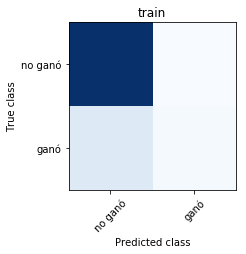

test ################################################################################
Precision: 0.6518833535844472
Recall: 0.17782565462379848
F1Score: 0.2794270833333333



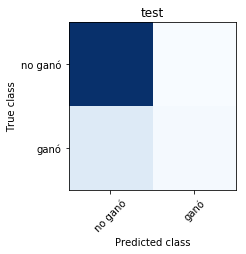

validation ################################################################################
Precision: 0.6267823930564166
Recall: 0.16943187531422826
F1Score: 0.26675461741424805



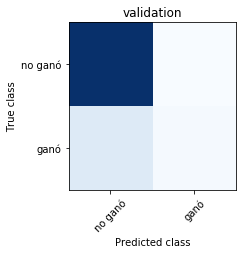

In [20]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs, False)

### Conclusión:

- Podemos concluir con que este modelo no es el apropiado para nuestro caso ya que no es linealmente divisibe, esto queda demostrado por los bajos valores que expresan las metricas seleccionadas.

### Neural Networks

- Decidimos probar con este modelo debido a que es uno de los más potentes

In [21]:
#Definimos función para calcular la métrica F

def f1(y_true, y_pred):
    def recall(y_true, y_pred):       
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):       
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
model = Sequential([   
    Dense(300, input_shape=(len(INPUTS_COLUMNS), )),
    Activation('tanh'),
    Dense(200),
    Activation('relu'),
    Dropout(0.10),
    Dense(100),
    Activation('tanh'),
    Dropout(0.05),
    Dense(1),
    Activation('sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[keras_metrics.precision(), keras_metrics.recall(), f1],
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
history = model.fit(
    lr_extract_inputs(train), 
    lr_extract_outputs(train),
    epochs=50,
    batch_size=100,
    validation_data=(
        lr_extract_inputs(test),
        lr_extract_outputs(test),
    )
)

Instructions for updating:
Use tf.cast instead.
Train on 123699 samples, validate on 41233 samples
Epoch 1/50
123699/123699 [==============================] - 19s 153us/step - loss: 0.3338 - precision: 0.6901 - recall: 0.1945 - f1: 0.2812 - val_loss: 0.2960 - val_precision: 0.6835 - val_recall: 0.3833 - val_f1: 0.4815
Epoch 2/50
123699/123699 [==============================] - 18s 144us/step - loss: 0.2887 - precision: 0.7394 - recall: 0.3619 - f1: 0.4714 - val_loss: 0.2736 - val_precision: 0.7449 - val_recall: 0.4254 - val_f1: 0.5310
Epoch 3/50
123699/123699 [==============================] - 18s 146us/step - loss: 0.2622 - precision: 0.7647 - recall: 0.4439 - f1: 0.5502 - val_loss: 0.2584 - val_precision: 0.7766 - val_recall: 0.4614 - val_f1: 0.5678
Epoch 4/50
123699/123699 [==============================] - 18s 146us/step - loss: 0.2406 - precision: 0.7834 - recall: 0.5010 - f1: 0.5996 - val_loss: 0.2558 - val_precision: 0.7575 - val_recall: 0.5131 - val_f1: 0.6024
Epoch 5/50
123699

123699/123699 [==============================] - 19s 154us/step - loss: 0.0868 - precision: 0.9014 - recall: 0.8316 - f1: 0.8601 - val_loss: 0.3295 - val_precision: 0.7667 - val_recall: 0.6561 - val_f1: 0.6990
Epoch 37/50
123699/123699 [==============================] - 20s 159us/step - loss: 0.0852 - precision: 0.9054 - recall: 0.8339 - f1: 0.8635 - val_loss: 0.3330 - val_precision: 0.7578 - val_recall: 0.6601 - val_f1: 0.6985
Epoch 38/50
123699/123699 [==============================] - 19s 151us/step - loss: 0.0854 - precision: 0.9051 - recall: 0.8324 - f1: 0.8630 - val_loss: 0.3387 - val_precision: 0.7341 - val_recall: 0.6684 - val_f1: 0.6926
Epoch 39/50
123699/123699 [==============================] - 19s 150us/step - loss: 0.0843 - precision: 0.9026 - recall: 0.8373 - f1: 0.8640 - val_loss: 0.3335 - val_precision: 0.7414 - val_recall: 0.6629 - val_f1: 0.6930
Epoch 40/50
123699/123699 [==============================] - 20s 159us/step - loss: 0.0814 - precision: 0.9081 - recall: 0.8

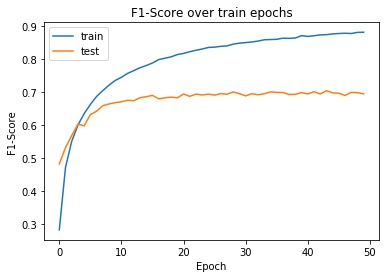

In [27]:
plt.plot(history.history['f1'], label='train')
plt.plot(history.history['val_f1'], label='test')
plt.title('F1-Score over train epochs')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Conclusión:

- Decidimos que este modelo es el apropiado ya que contamos con una gran cantidad de datos y no pudimos encontrar resultados satisfactorios con modelos más simples. Observamos que los resultados de las métricas, si bien no son los ideales, cumplen con nuestras expectativas.

### Random Forests

- Decidimos probar con éste modelo ya que queríamos evaluar su desempeño en nuestro caso, pese a saber que existen grandes probabilidades de que sobre-entrene (por la gran cantidad de clases que tienen nuestras variables)

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
#Separamos el conjunto de datos en: train, test y validation
train_tree, not_train_tree = train_test_split(data_tree, test_size=0.4)
validation_tree, test_tree = train_test_split(not_train_tree, test_size=0.5)

In [30]:
INPUTS = [
 'sex', 
 'age', 
 'height', 
 'weight', 
 'noc', 
 'year', 
 'season', 
 'city',       
 'sport', 
 'event']

def tree_extract_inputs(data_tree):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = data_tree.copy()
    
    # sex to labels
    inputs['sex'] = inputs.sex.map({'M': 1, 'F': 2})

    #noc
    i = 0
    for noc in data_tree.noc.unique():
        i += 1
        inputs.at[inputs.noc == noc, "noc"] = i
        
    i = 0
    for season in data_tree.season.unique():
        i += 1
        inputs.at[inputs.season == season, "season"] = i
    
    i = 0
    for city in data_tree.city.unique():
        i += 1
        inputs.at[inputs.city == city, "city"] = i
    
    i = 0
    for sport in data_tree.sport.unique():
        i += 1
        inputs.at[inputs.sport == sport, "sport"] = i

        
    i = 0
    for event in data_tree.event.unique():
        i += 1
        inputs.at[inputs.event == event, "event"] = i
 
    # return the raw numbers
    return inputs[INPUTS].values

def tree_extract_outputs(data_tree):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return data_tree.medal.values

In [31]:
forest_model = RandomForestClassifier()

In [32]:
forest_model.fit(
    tree_extract_inputs(train_tree),
    tree_extract_outputs(train_tree),
)

/home/lucas/analisis_exploratorio/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train ################################################################################
Precision: 0.9984259595592687
Recall: 0.9175986201524509
F1Score: 0.9563074425212373



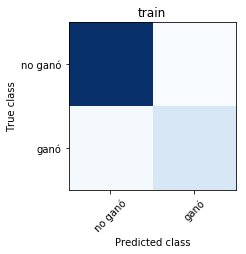

test ################################################################################
Precision: 0.2995391705069124
Recall: 0.021364009860312245
F1Score: 0.039883417702101555



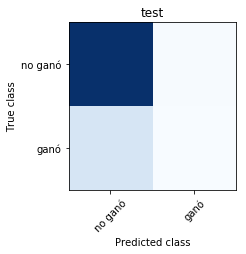

validation ################################################################################
Precision: 0.23869346733668342
Recall: 0.015515270292340356
F1Score: 0.029136635485355004



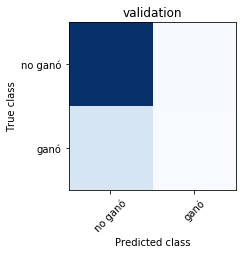

In [33]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs, True)

### Conclusión:

- Decimos no considerar este modelo para predecir ya que los resultados obtenidos a partir de las métricas, a nuestro criterio, son insuficientes. Esto ocurre debido a que el modelo sobre-entrena por la gran cantidad de clases que tienen nuestras variables.

## Técnicas para garantizar que los modelos no sobre-entrenen

- Para garantizar que los modelos no sobreentrenen decidimos utilizar como métrica la **matriz de confusión**, la cual nos permite comparar de manera visual y rápida los resultados obtenidos en train y test (para el modelo de regresión logística y para random forest). Y para el modelo que consideramos más apropiado (redes neuranales) utilizamos la métrica **curva de apredizaje** para poder encontrar la cantidad de épocas necesarias para obtener resultados satifactorios sin que el modelo llegue a sobre-entrenar y además utiliamos la técnica de **dropout** a fin de cortar conexiones entre las neuronas previniendo el sobreentrenamiento.

## Conclusión final 

- El valor final de la métrica es: 0.70 (0.6945 en el dataset de test), esto indica una ponderación entre la cantidad de falsos positivos que estamos dispuestos a aceptar (1 - precission) y la probabilidad de que no se nos escape un caso positivo. Como explicamos más arriba, es una especie de promedio entre precission, que indica el porcentaje de seguridad que tenemos al decír que nuestra predicción pertenece a la clase indicada, y recall, que indica de la cantidad total de casos que había, cuantos fuimos capaces de predecir correctamente.

    Como síntesis, podemos decirle al cliente que tenemos una certeza de predicción aproximada al 70% al decir si un atleta es medallista olimipico o no.